In [1]:
import numpy as np
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
# Set up folder with data:
os.chdir('D:\\01_PROJECTS_sripts_code\\Electricty_Demand\\02_FORECAST')

In [3]:
#%% Function to extract code from GitHub:
def GetGitHubCode(GitUrl):

    response = requests.get(GitUrl) #get data from json file located at specified URL 

    if response.status_code == requests.codes.ok:
        contentOfUrl = response.content
        exec(contentOfUrl, globals() )
    else:
        print('Content was not found.')

In [4]:
# Download functions from GitHub:
GitUrl__Prepare_Data_For_Regression = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Prepare_Data_For_Regression.py'
GetGitHubCode(GitUrl__Prepare_Data_For_Regression)

GitUrl__Make_TS_Regression = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Make_TS_Regression.py'
GetGitHubCode(GitUrl__Make_TS_Regression)

GitUrl__Goodness_Of_Fit = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Goodness_Of_Fit.py'
GetGitHubCode(GitUrl__Goodness_Of_Fit)

GitUrl__Multicollinearity_Check_Functions = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Multicollinearity_Check_Functions.py'
GetGitHubCode(GitUrl__Multicollinearity_Check_Functions)

GitUrl__Feature_Selection = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Feature_Selection.py'
GetGitHubCode(GitUrl__Feature_Selection)

GitUrl__ANN_Keras_functions = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/ANN_Keras_functions.py'
GetGitHubCode(GitUrl__ANN_Keras_functions)

In [5]:
# Read Analysis Data:
AnalysisData = pd.read_csv('AnalysisDF.csv',
                           parse_dates =['Date'],
                           index_col = 'Date')

AnalysisData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63552 entries, 2015-07-01 01:00:00 to 2022-09-30 00:00:00
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Demand               63552 non-null  float64
 1   air_temperature      63552 non-null  float64
 2   humidity             63552 non-null  float64
 3   sky_cover            63552 non-null  float64
 4   wind_speed           63552 non-null  float64
 5   Population           63552 non-null  float64
 6   RealGDP              63552 non-null  float64
 7   DallasFedManufIndex  63552 non-null  float64
 8   WorkDay              63552 non-null  int64  
 9   hour                 63552 non-null  int64  
 10  day                  63552 non-null  int64  
 11  week                 63552 non-null  int64  
 12  month                63552 non-null  int64  
 13  HDD                  63552 non-null  int64  
 14  CDD                  63552 non-null  int64  
dtypes

In [6]:
##########################################################
##########################################################
#%% Prepare data
##########################################################
##########################################################

In [7]:
# Select Main Data
Dependent_Var = 'Demand'

Independent_Vars = ['HDD',
                    'CDD',
                    'wind_speed',
                    'humidity',
                    'sky_cover',
#                   'Population',
                    'RealGDP',
                    'DallasFedManufIndex',
                    'WorkDay',
                    'hour',
#                   'day',
                    'week'
#                   'month'
                   ]

DummyForColumn = ['hour','week']
LagList = None

In [8]:
# Add Lags
LagWindow = 48
LagsRengeList ={'Demand':48,
                'HDD':LagWindow,
                'CDD':LagWindow,
                'wind_speed':LagWindow,
                'humidity':LagWindow,
                'sky_cover':LagWindow,  
                }


LagList = MakeLagedVariableNames(LagsRangeList= LagsRengeList,\
                                 LagsDirectList = None)

AnalysisData = PrepareLags(AnalysisData, LagList)
Independent_Vars.extend( LagList.keys() )

<string>:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [9]:
### Cut data to pre-Covid time and crate 2 datasets to show diffrence between a summer and winter predictions

In [10]:
###################
#%% '01' model on winter time
###################

In [11]:
AnalysisData_01 = AnalysisData.loc[:'2020-02']

In [12]:
ValSetDate_01 = '2019-05'
TestSetDate_01 = '2019-09'

In [13]:
# Prepare Data For ANN
X_01, y_01 =  DevideOnXandY_CreateDummies(AnalysisData_01, 
                                          DependentVar = Dependent_Var,
                                          IndependentVar = Independent_Vars,
                                          DummyForCol = DummyForColumn)

X_Train_sld_01, y_Train_sld_01,\
X_Val_sld_01, y_Val_sld_01,\
X_Test_sld_01, y_Test_sld_01,\
scaler_X_01, scaler_y_01 = \
            PrepareDataForRegression(X_01, y_01, 
                                     TestSplitInd = TestSetDate_01,
                                     ValSplitInd = ValSetDate_01,     
                                     ScalerType = 'MinMax',
                                     ScalerRange = (0,1),                             
                                     BatchSize = None,
                                     WindowLength = 1)

y_Test_01 = AnalysisData_01.loc[y_Test_sld_01.index][['Demand']]

In [14]:
###################
#%% '02' model on summer time
###################

In [15]:
AnalysisData_02 = AnalysisData.loc[:'2019-07']

In [16]:
ValSetDate_02 = '2018-10'
TestSetDate_02 = '2019-02'

In [17]:
# Prepare Data for ANN
X_02, y_02 =  DevideOnXandY_CreateDummies(AnalysisData_02, 
                                          DependentVar = Dependent_Var,
                                          IndependentVar = Independent_Vars,
                                          DummyForCol = DummyForColumn)

X_Train_sld_02, y_Train_sld_02,\
X_Val_sld_02, y_Val_sld_02,\
X_Test_sld_02, y_Test_sld_02,\
scaler_X_02, scaler_y_02 = \
            PrepareDataForRegression(X_02, y_02, 
                                     TestSplitInd = TestSetDate_02,
                                     ValSplitInd = ValSetDate_02,     
                                     ScalerType = 'MinMax',
                                     ScalerRange = (0,1),                             
                                     BatchSize = None,
                                     WindowLength = 1)

y_Test_02 = AnalysisData_02.loc[y_Test_sld_02.index][['Demand']]

In [18]:
##########################################################
##########################################################
#%% FIT MODEL - hyperparameter tuning
##########################################################
##########################################################

In [19]:
r_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=0.01,
                    decay_steps=1000,
                    decay_rate=0.5)


ParameterForSearch = dict(HiddenLayersNumber = [1,2,3,4,5],
                          NeuronsNumber = [25, 50, 150, 200, 250],\
                          InputShape = [(X_Train_sld_01.shape[1], )],
                          AddBatchNorm = [False, True],\
                          LossFun = ['mean_squared_error'],\
                          Opt = ['Adam()',
                                 'Nadam()',
                                 'SGD(learning_rate=0.01, decay=0.0, momentum=0.9, nesterov=False)',
                                 'SGD(learning_rate=0.1, decay=0.01, momentum=0.9, nesterov=False)',
                                 'SGD(learning_rate=0.1, decay=0.001, momentum=0.9, nesterov=False)',
                                 'SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=Flase)'],\
                          ActivationFun = ['relu', 'LeakyReLU', 'ELU', 'swish'],\
                          ActivationOut = ['linear'],\
                          nb_epoch = [10,20,30,50,70,90,110],\
                          batch_size = [10,20,50,70],
                          DropoutValue = [0.2],\
                          init = ['glorot_uniform', 'uniform','normal'] )
    
WrapedANNmodel = KerasRegressor(build_fn = CreateFeedForwardModel)
# Annmodel_GridSearch = GridSearchCV(WrapedANNmodel, ParameterForSearch, cv = 6)
ANNmodel_RandomSearch = RandomizedSearchCV(WrapedANNmodel, ParameterForSearch, cv = 6)

Search_Results = ANNmodel_RandomSearch.fit( X_Train_sld_01, y_Train_sld_01 )

80/80 [==============================] - 0s 867us/step - loss: 0.0164 - mean_squared_error: 0.0164 - lr: 0.0200


C:\Users\kamil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-0.0019683  -0.00163284 -0.00370601 -0.02302786 -0.00144628 -0.00263458
 -0.00890306 -0.00191398         nan -0.03839506]
  warnings.warn(


480/480 [==============================] - 2s 4ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - lr: 0.0816


In [20]:
Search_Results.best_params_

{'nb_epoch': 30,
 'init': 'uniform',
 'batch_size': 70,
 'Opt': 'SGD(learning_rate=0.1, decay=0.001, momentum=0.9, nesterov=False)',
 'NeuronsNumber': 250,
 'LossFun': 'mean_squared_error',
 'InputShape': (371,),
 'HiddenLayersNumber': 4,
 'DropoutValue': 0.2,
 'AddBatchNorm': False,
 'ActivationOut': 'linear',
 'ActivationFun': 'ELU'}

In [21]:
##########################################################
# Final Model - define and fit
##########################################################

In [22]:
###################
#%% '01' model on winter time
###################

In [25]:
#Final_Model_01.reset_states()

Final_Model_01 = \
    CreateFeedForwardModel(\
            HiddenLayersNumber = Search_Results.best_params_['HiddenLayersNumber'],\
            NeuronsNumber      = Search_Results.best_params_['NeuronsNumber'],\
            InputShape         = Search_Results.best_params_['InputShape'],\
            AddBatchNorm       = Search_Results.best_params_['AddBatchNorm'],\
            LossFun            = Search_Results.best_params_['LossFun'],\
            Opt                = Search_Results.best_params_['Opt'],\
            ActivationFun      = Search_Results.best_params_['ActivationFun'],\
            DropoutValue       = Search_Results.best_params_['DropoutValue'],\
            init               = Search_Results.best_params_['init']
                           )


Final_Model_history_01 = \
    Final_Model_01.fit(X_Train_sld_01, y_Train_sld_01,\
                       validation_data = (X_Val_sld_01, y_Val_sld_01),\
                       epochs = Search_Results.best_params_['nb_epoch']+5,\
                       batch_size = Search_Results.best_params_['batch_size'])

Epoch 1/35
480/480 [==============================] - 2s 4ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - lr: 0.0816 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_lr: 0.0676
Epoch 2/35
480/480 [==============================] - 2s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - lr: 0.0585 - val_loss: 8.7241e-04 - val_mean_squared_error: 8.7241e-04 - val_lr: 0.0510
Epoch 3/35
480/480 [==============================] - 2s 3ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - lr: 0.0456 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - val_lr: 0.0410
Epoch 4/35
480/480 [==============================] - 2s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - lr: 0.0374 - val_loss: 6.6042e-04 - val_mean_squared_error: 6.6042e-04 - val_lr: 0.0342
Epoch 5/35
480/480 [==============================] - 2s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - lr: 0.0317 - val_loss: 6.6692e-04 - val_mean_squared_error: 6.6692e-04 - val_lr: 0.0294
Epoch 6/35
480/4

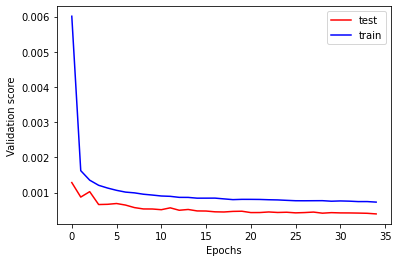

In [26]:
PlotLossTrainVsVal(Final_Model_history_01)

In [ ]:
###################
#%% '02' model on summer time
###################

In [27]:
Final_Model_02 = \
    CreateFeedForwardModel(\
            HiddenLayersNumber = Search_Results.best_params_['HiddenLayersNumber'],\
            NeuronsNumber      = Search_Results.best_params_['NeuronsNumber'],\
            InputShape         = Search_Results.best_params_['InputShape'],\
            AddBatchNorm       = Search_Results.best_params_['AddBatchNorm'],\
            LossFun            = Search_Results.best_params_['LossFun'],\
            Opt                = Search_Results.best_params_['Opt'],\
            ActivationFun      = Search_Results.best_params_['ActivationFun'],\
            DropoutValue       = Search_Results.best_params_['DropoutValue'],\
            init               = Search_Results.best_params_['init']
                           )


Final_Model_history_02 = \
    Final_Model_02.fit(X_Train_sld_02, y_Train_sld_02,\
                       validation_data = (X_Val_sld_02, y_Val_sld_02),\
                       epochs = Search_Results.best_params_['nb_epoch']+5,\
                       batch_size = Search_Results.best_params_['batch_size'])

Epoch 1/35
407/407 [==============================] - 2s 5ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - lr: 0.0839 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - val_lr: 0.0711
Epoch 2/35
407/407 [==============================] - 2s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - lr: 0.0624 - val_loss: 9.7492e-04 - val_mean_squared_error: 9.7492e-04 - val_lr: 0.0551
Epoch 3/35
407/407 [==============================] - 2s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - lr: 0.0497 - val_loss: 9.3526e-04 - val_mean_squared_error: 9.3526e-04 - val_lr: 0.0450
Epoch 4/35
407/407 [==============================] - 2s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - lr: 0.0413 - val_loss: 7.9658e-04 - val_mean_squared_error: 7.9658e-04 - val_lr: 0.0381
Epoch 5/35
407/407 [==============================] - 2s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - lr: 0.0354 - val_loss: 8.0055e-04 - val_mean_squared_error: 8.0055e-04 - val_lr: 0.0329
Epoch 6/

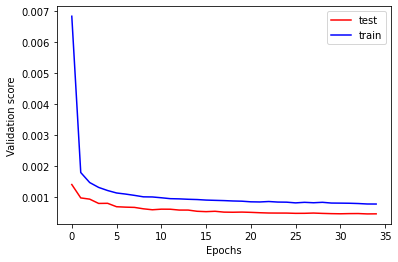

In [28]:
PlotLossTrainVsVal(Final_Model_history_02)

In [ ]:
##########################################################
##########################################################
#%% Check Model - Test Set
##########################################################
##########################################################

In [ ]:
###################
#%% test '01' model on winter time
###################

In [29]:
# Make prediction on test set
yhat_Test_ANN_01, X_Test_ANN_01 = \
     MakeTSforecast(X_Test_sld_01,\
                    Model = Final_Model_01,\
                    DependentVar = Dependent_Var,\
                    Intecept = False,\
                    LagsList = LagList,\
                    Scaler_y = scaler_y_01,\
                    Scaler_X = scaler_X_01,\
                    Test_or_Forecast = 'Test')
        
        
DataWithPrediction_01 =\
    MakeANNfinalData(Model = Final_Model_01,\
                     Train_X_Scaled = X_Train_sld_01,\
                     Val_X_Scaled = X_Val_sld_01,\
                     Scaler_y = scaler_y_01,\
                     MainDF = AnalysisData_01,\
                     yhat_Test_DF = yhat_Test_ANN_01,\
                     yhat_Forecast_DF = None)

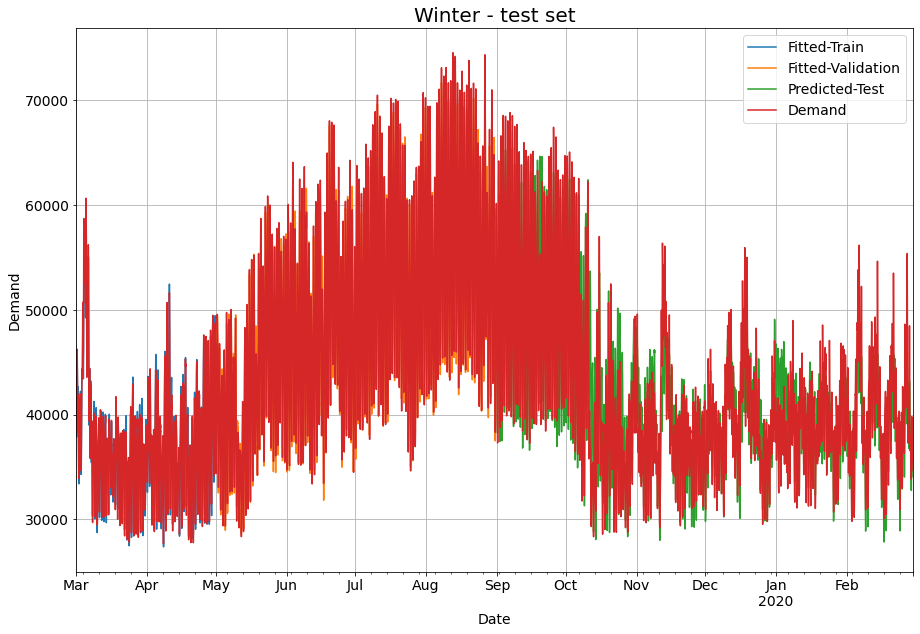

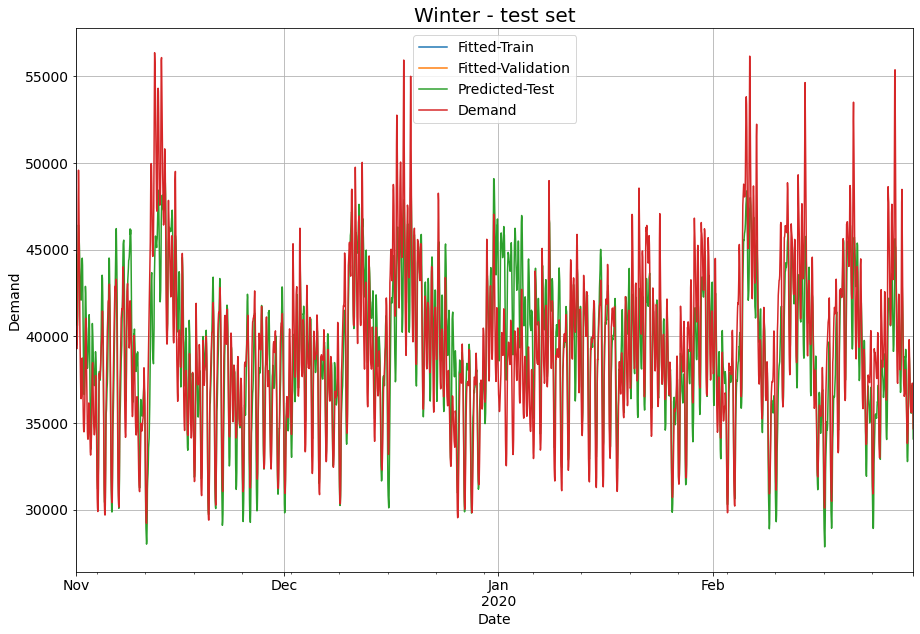

In [31]:
# Plot Fitted Data
DataWithPrediction_01[['Fitted-Train','Fitted-Validation','Predicted-Test',Dependent_Var]]\
                .loc['2019-03':]\
                .plot()

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()


DataWithPrediction_01[['Fitted-Train','Fitted-Validation','Predicted-Test',Dependent_Var]]\
                .loc['2019-11':]\
                .plot()

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [32]:
print( CalculateR2andR2adj(y_Test_01, yhat_Test_ANN_01, X_Test_sld_01, const = False) )
print('')
print( f'MAE:  {round(mean_absolute_error(y_Test_01, yhat_Test_ANN_01),2)}'  )
print( f'MAPE: {round(mean_absolute_percentage_error(y_Test_01, yhat_Test_ANN_01)*100,2)}' )
print( f'RSME: {round(np.sqrt(mean_squared_error(y_Test_01, yhat_Test_ANN_01)),2)}' )

R2: 0.8796
R2_adj: 0.8685
(0.8796, 0.8685)

MAE:  2000.5
MAPE: 4.89
RSME: 2707.01


In [ ]:
###################
#%% test '02' model on  summer time
###################

In [33]:
# Make prediction on test set
yhat_Test_ANN_02, X_Test_ANN_02 = \
     MakeTSforecast(X_Test_sld_02,\
                    Model = Final_Model_02,\
                    DependentVar = Dependent_Var,\
                    Intecept = False,\
                    LagsList = LagList,\
                    Scaler_y = scaler_y_02,\
                    Scaler_X = scaler_X_02,\
                    Test_or_Forecast = 'Test')
        
        
DataWithPrediction_02 =\
    MakeANNfinalData(Model = Final_Model_02,\
                     Train_X_Scaled = X_Train_sld_02,\
                     Val_X_Scaled = X_Val_sld_02,\
                     Scaler_y = scaler_y_02,\
                     MainDF = AnalysisData_02,\
                     yhat_Test_DF = yhat_Test_ANN_02,\
                     yhat_Forecast_DF = None)

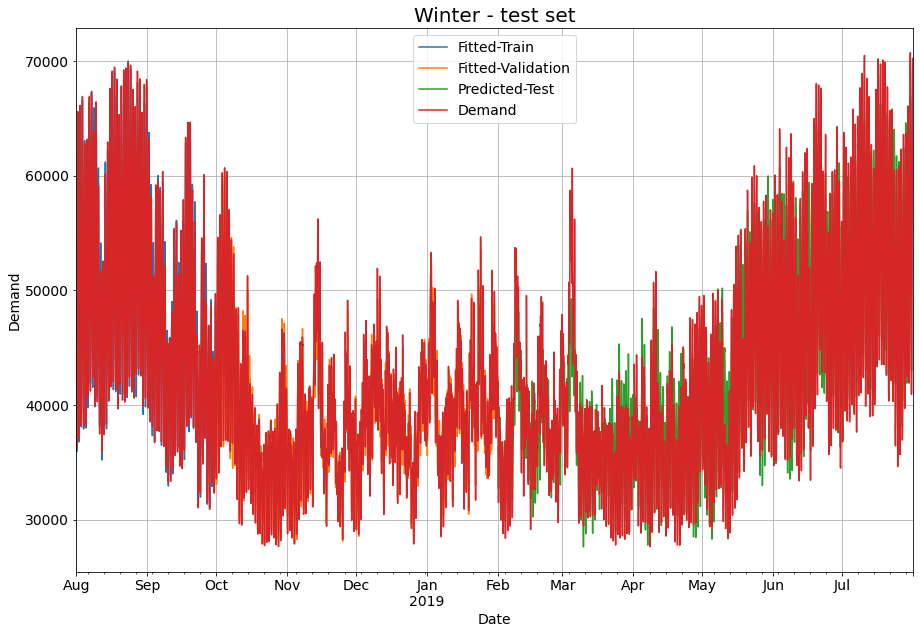

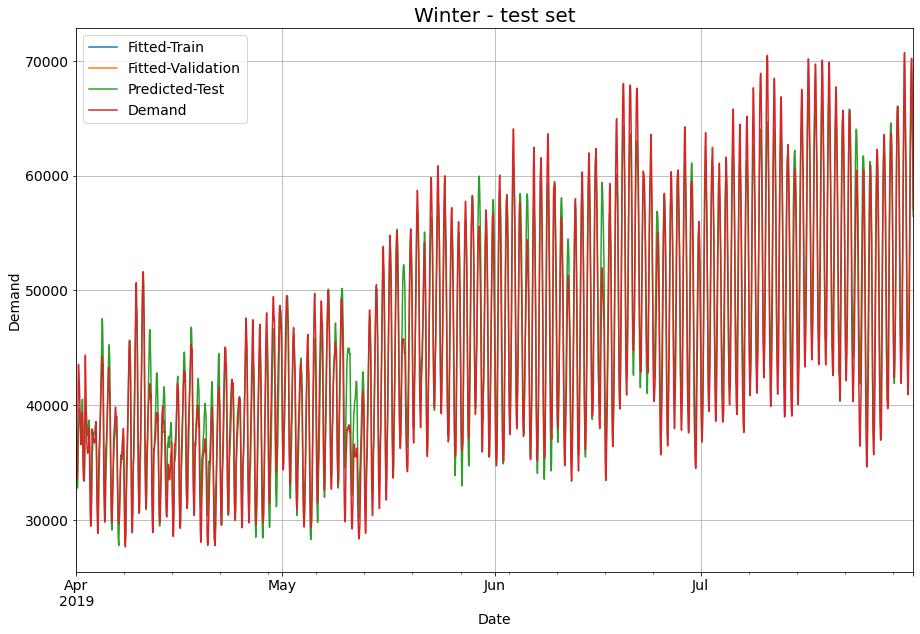

In [34]:
# Plot Fitted Data
DataWithPrediction_02[['Fitted-Train','Fitted-Validation','Predicted-Test',Dependent_Var]]\
                .loc['2018-08':]\
                .plot()

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()


DataWithPrediction_02[['Fitted-Train','Fitted-Validation','Predicted-Test',Dependent_Var]]\
                .loc['2019-04':]\
                .plot()

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [35]:
print( CalculateR2andR2adj(y_Test_02, yhat_Test_ANN_02, X_Test_sld_02, const = False) )
print('')
print( f'MAE:  {round(mean_absolute_error(y_Test_02, yhat_Test_ANN_02),2)}'  )
print( f'MAPE: {round(mean_absolute_percentage_error(y_Test_02, yhat_Test_ANN_02)*100,2)}' )
print( f'RSME: {round(np.sqrt(mean_squared_error(y_Test_02, yhat_Test_ANN_02)),2)}' )

R2: 0.9296
R2_adj: 0.923
(0.9296, 0.923)

MAE:  1894.15
MAPE: 4.47
RSME: 2500.53
